### **Alzheimer** **Dataset**

Alzheimer’s is a progressive disease, where dementia symptoms gradually worsen over a number of years. In its early stages, memory loss is mild, but with late-stage Alzheimer’s, individuals lose the ability to carry on a conversation and respond to their environment.
Image Processing plays an important role in the early detection of Alzheimer’s disease so that patients can be prevented before irreversible changes occur in the brain.

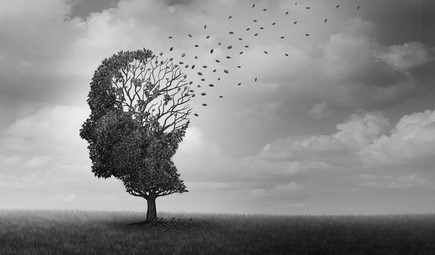

## Library Imports


In [ ]:
import os
import glob
import pickle
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import skimage.io as io
from skimage.transform import resize
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import mobilenet_v2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import keras
from sklearn.utils import compute_class_weight 
from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator, save_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential, Model, load_model, model_from_json
from tensorflow.keras.layers import (Input, InputLayer, Conv2D, MaxPooling2D, Dense, BatchNormalization, Dropout, Activation, GlobalAveragePooling2D, InputSpec, Flatten, Concatenate)
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.metrics import Accuracy, AUC, Precision, Recall
import warnings
warnings.filterwarnings("ignore")

## Uploading the dataset

In [ ]:
!unzip aaa.zip

Streaming output truncated to the last 5000 lines.
  inflating: Data-Alzheimer-with-FCIE/train/NonDemented/27 (41).jpg  
  inflating: Data-Alzheimer-with-FCIE/train/NonDemented/27 (42).jpg  
  inflating: Data-Alzheimer-with-FCIE/train/NonDemented/27 (43).jpg  
  inflating: Data-Alzheimer-with-FCIE/train/NonDemented/27 (45).jpg  
  inflating: Data-Alzheimer-with-FCIE/train/NonDemented/27 (46).jpg  
  inflating: Data-Alzheimer-with-FCIE/train/NonDemented/27 (47).jpg  
  inflating: Data-Alzheimer-with-FCIE/train/NonDemented/27 (48).jpg  
  inflating: Data-Alzheimer-with-FCIE/train/NonDemented/27 (49).jpg  
  inflating: Data-Alzheimer-with-FCIE/train/NonDemented/27 (50).jpg  
  inflating: Data-Alzheimer-with-FCIE/train/NonDemented/27 (51).jpg  
  inflating: Data-Alzheimer-with-FCIE/train/NonDemented/27 (53).jpg  
  inflating: Data-Alzheimer-with-FCIE/train/NonDemented/27 (54).jpg  
  inflating: Data-Alzheimer-with-FCIE/train/NonDemented/27 (55).jpg  
  inflating: Data-Alzheimer-with-FCIE/t

####Installing random numbers

In [ ]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
pd.set_option('display.max_colwidth' , 200)

In [ ]:
TRAIN_DIR ='/content/Data-Alzheimer-with-FCIE/train/'
VAL_DIR ='/content/Data-Alzheimer-with-FCIE/val/'
TEST_DIR ='/content/Data-Alzheimer-with-FCIE/test/'

### Class label extraction

In [ ]:
classes = os.listdir(TRAIN_DIR)
class2label = {}

for i in range(len(classes)):
    class2label[classes[i]] = i
    
label2class = {v:k for k, v in class2label.items()}

print(class2label)
print("--"*45)
print(label2class)

{'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}
------------------------------------------------------------------------------------------
{0: 'MildDemented', 1: 'ModerateDemented', 2: 'NonDemented', 3: 'VeryMildDemented'}


### Extracting types and number of images 

In [ ]:
train_distribution = {}
print("TRAIN-SET DISTRIBUTION\n")
for cat in classes:
    path = os.path.join(TRAIN_DIR, cat, "*")
    data = glob.glob(path)
    print(f"Number of {cat} Images: {len(data)}")
    train_distribution[cat] = len(data)
    print('--'*20)   

test_distribution = {}
print("\nVAL-SET DISTRIBUTION\n")
for cat in classes:
    path = os.path.join(VAL_DIR, cat, "*")
    data = glob.glob(path)
    print(f"Number of {cat} Images: {len(data)}")
    test_distribution[cat] = len(data)
    print('--'*20)
    
test_distribution = {}
print("\nTEST-SET DISTRIBUTION\n")
for cat in classes:
    path = os.path.join(TEST_DIR, cat, "*")
    data = glob.glob(path)
    print(f"Number of {cat} Images: {len(data)}")
    test_distribution[cat] = len(data)
    print('--'*20)

TRAIN-SET DISTRIBUTION

Number of MildDemented Images: 686
----------------------------------------
Number of ModerateDemented Images: 49
----------------------------------------
Number of NonDemented Images: 2448
----------------------------------------
Number of VeryMildDemented Images: 1714
----------------------------------------

VAL-SET DISTRIBUTION

Number of MildDemented Images: 121
----------------------------------------
Number of ModerateDemented Images: 9
----------------------------------------
Number of NonDemented Images: 432
----------------------------------------
Number of VeryMildDemented Images: 302
----------------------------------------

TEST-SET DISTRIBUTION

Number of MildDemented Images: 89
----------------------------------------
Number of ModerateDemented Images: 6
----------------------------------------
Number of NonDemented Images: 320
----------------------------------------
Number of VeryMildDemented Images: 224
----------------------------------------


Extracting categories, image name, image id, image format, labels, img path, img height and img width 

In [ ]:
categories = []
image_name = []
image_id = []
image_format = []
labels = []
img_path = []
img_height = []
img_width = []

for cat in classes:
    path = os.path.join(TRAIN_DIR, cat, "*")
    data = glob.glob(path)
    for i in range(len(data)):
        h, w, c = cv2.imread(data[i]).shape
        cls , img = data[i].split('/')[-2:]
        img_id , img_format = img.split('.')
        img_height.append(h)
        img_width.append(w)
        categories.append(cls)
        image_name.append(img)
        image_id.append(img_id)
        image_format.append(img_format) 
        labels.append(class2label[cls])
        img_path.append(data[i])

In [ ]:
assert len(categories) == len(image_name) == len(image_id) == len(image_id) == len(image_format) == len(labels) == len(img_path) == len(img_height) == len(img_width)

### Displayed as Dataframe

In [ ]:
data = pd.DataFrame(list(zip(image_id, image_name, image_format, categories, labels, img_path, img_height, img_width)))
data.columns = ['image_id' , 'image_name' , 'format' , 'Class' , 'label' , 'image_path' , 'height' , 'width']
data.sample(10 , random_state = SEED)

,image_id,image_name,format,Class,label,image_path,height,width
144,mildDem183,mildDem183.jpg,jpg,MildDemented,0,/content/Data-Alzheimer-with-FCIE/train/MildDemented/mildDem183.jpg,208,176
79,29 (24),29 (24).jpg,jpg,MildDemented,0,/content/Data-Alzheimer-with-FCIE/train/MildDemented/29 (24).jpg,208,176
4630,verymildDem1070,verymildDem1070.jpg,jpg,VeryMildDemented,3,/content/Data-Alzheimer-with-FCIE/train/VeryMildDemented/verymildDem1070.jpg,208,176
1860,nonDem1799,nonDem1799.jpg,jpg,NonDemented,2,/content/Data-Alzheimer-with-FCIE/train/NonDemented/nonDem1799.jpg,208,176
4880,verymildDem1436,verymildDem1436.jpg,jpg,VeryMildDemented,3,/content/Data-Alzheimer-with-FCIE/train/VeryMildDemented/verymildDem1436.jpg,208,176
1831,nonDem2100,nonDem2100.jpg,jpg,NonDemented,2,/content/Data-Alzheimer-with-FCIE/train/NonDemented/nonDem2100.jpg,208,176
756,nonDem1279,nonDem1279.jpg,jpg,NonDemented,2,/content/Data-Alzheimer-with-FCIE/train/NonDemented/nonDem1279.jpg,208,176
4194,verymildDem1471,verymildDem1471.jpg,jpg,VeryMildDemented,3,/content/Data-Alzheimer-with-FCIE/train/VeryMildDemented/verymildDem1471.jpg,208,176
287,mildDem493,mildDem493.jpg,jpg,MildDemented,0,/content/Data-Alzheimer-with-FCIE/train/MildDemented/mildDem493.jpg,208,176
2615,32 (81),32 (81).jpg,jpg,NonDemented,2,/content/Data-Alzheimer-with-FCIE/train/NonDemented/32 (81).jpg,208,176


### Data Visualization


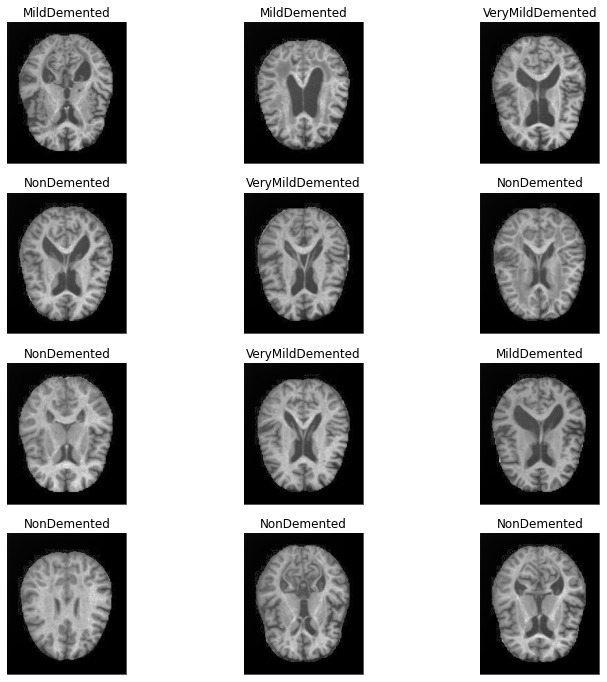

In [ ]:
sample_data = data.sample(12 , random_state = SEED)
sample_imgs = sample_data['image_path'].to_list()

plt.figure(figsize = (12,12))
for i in range(12):
    plt.subplot(4 , 3 , i+1)
    img = cv2.imread(sample_imgs[i])
    plt.title(sample_imgs[i].split('/')[-2], fontsize = 12)
    plt.axis('off')
    plt.imshow(img)
    
plt.savefig("brainPlots.png")

In [ ]:
BATCH_SIZE = 64
NUM_EPOCHS = 40
IMG_SIZE = (224,224)
INPUT_SHAPE = (224,224,3)

### Data Splitting


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True,
                                   brightness_range = [0.6, 1.4],
                                   rotation_range = 15)

val_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = TRAIN_DIR,
                                                   target_size = IMG_SIZE,
                                                   color_mode = "rgb",
                                                   class_mode = "categorical",
                                                   batch_size = BATCH_SIZE,
                                                   interpolation = "bicubic" ,
                                                   shuffle = True)    

val_dataset = val_datagen.flow_from_directory(directory = VAL_DIR,
                                                target_size = IMG_SIZE,
                                               color_mode = "rgb",
                                               class_mode = "categorical",
                                               batch_size = BATCH_SIZE,
                                               interpolation = "bicubic")

test_dataset = test_datagen.flow_from_directory(directory = TEST_DIR,
                                               target_size = IMG_SIZE,
                                               color_mode = "rgb",
                                               class_mode = "categorical",
                                               batch_size = BATCH_SIZE,
                                               interpolation = "bicubic",
                                               shuffle = False)

Found 4897 images belonging to 4 classes.
Found 864 images belonging to 4 classes.
Found 639 images belonging to 4 classes.


In [ ]:
print('Number of batch iterations on training data' , len(train_dataset))
print('Number of batch iterations on validation data' , len(val_dataset))
print('Number of batch iterations on test data' , len(test_dataset))

Number of batch iterations on training data 77
Number of batch iterations on validation data 14
Number of batch iterations on test data 10


In [ ]:
label2class = train_dataset.class_indices
class2label = {v:k for (k,v) in train_dataset.class_indices.items()}

print(label2class)
print(class2label)

{'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}
{0: 'MildDemented', 1: 'ModerateDemented', 2: 'NonDemented', 3: 'VeryMildDemented'}


### Temporary file saves the model

In [ ]:
os.mkdir("./temp/")
checkpoint_filepath = "./temp/"

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, mode='min', verbose=1)
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
lr_reduction = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min")
callbacks_list = [early_stop, lr_reduction, checkpoint]

### **Transfer** **Learning**


###### Using MobileNetV2

In [ ]:
model_1 = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE) 

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
for layer in model_1.layers:
    layer.trainable = False    

In [ ]:
mobilenet= Sequential(
                        [InputLayer(input_shape=INPUT_SHAPE),model_1,
                         Flatten(),  
                         Dense(3000, activation='relu'),   
                         Dense(1500, activation='relu'),   
                         Dense(4, activation='softmax')]
                       )

In [ ]:
mobilenet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 3000)              188163000 
                                                                 
 dense_1 (Dense)             (None, 1500)              4501500   
                                                                 
 dense_2 (Dense)             (None, 4)                 6004      
                                                                 
Total params: 194,928,488
Trainable params: 192,670,504
Non-trainable params: 2,257,984
__________________________________

In [ ]:
mobilenet.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'],)

In [ ]:
result_mobilenet = mobilenet.fit(train_dataset,epochs=NUM_EPOCHS, callbacks=[callbacks_list],validation_data=val_dataset)

Epoch 1/40
77/77 [==============================] - ETA: 0s - loss: 12.3858 - accuracy: 0.4823
Epoch 00001: val_loss improved from inf to 0.93255, saving model to ./temp/
INFO:tensorflow:Assets written to: ./temp/assets
77/77 [==============================] - 153s 2s/step - loss: 12.3858 - accuracy: 0.4823 - val_loss: 0.9325 - val_accuracy: 0.5660 - lr: 0.0010
Epoch 2/40
77/77 [==============================] - ETA: 0s - loss: 0.8357 - accuracy: 0.6159
Epoch 00002: val_loss improved from 0.93255 to 0.84354, saving model to ./temp/
INFO:tensorflow:Assets written to: ./temp/assets
77/77 [==============================] - 142s 2s/step - loss: 0.8357 - accuracy: 0.6159 - val_loss: 0.8435 - val_accuracy: 0.6308 - lr: 0.0010
Epoch 3/40
77/77 [==============================] - ETA: 0s - loss: 0.7953 - accuracy: 0.6381
Epoch 00003: val_loss improved from 0.84354 to 0.81428, saving model to ./temp/
INFO:tensorflow:Assets written to: ./temp/assets
77/77 [==============================] - 141s 2

### **Plot** **Graph** 

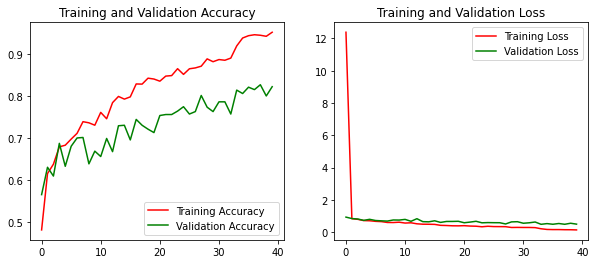

In [ ]:
acc = result_mobilenet.history['accuracy']
val_acc = result_mobilenet.history['val_accuracy']

loss = result_mobilenet.history['loss']
val_loss = result_mobilenet.history['val_loss']

epochs=40
epochs_range = range(epochs)


plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy', color = 'red') #, color = 'red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy',color='green')  # , color='blue')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss',color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss',color='green')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


###### Using VGG19

In [ ]:
model_2 = VGG19(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)  

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
# Freeze convolutional layers
for layer in model_2.layers:
    layer.trainable = False

In [ ]:
VGG19_model= Sequential(
                        [InputLayer(input_shape=INPUT_SHAPE),model_2,
                         Flatten(), 
                         Dense(3000, activation='relu'),   
                         Dense(1500, activation='relu'),  
                         Dense(4, activation='softmax')]
                       )

In [ ]:
VGG19_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 3000)              75267000  
                                                                 
 dense_4 (Dense)             (None, 1500)              4501500   
                                                                 
 dense_5 (Dense)             (None, 4)                 6004      
                                                                 
Total params: 99,798,888
Trainable params: 79,774,504
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
VGG19_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'],)

In [ ]:
result_VGG19 = VGG19_model.fit(train_dataset,epochs=NUM_EPOCHS, callbacks=[callbacks_list],validation_data=val_dataset)

Epoch 1/40
77/77 [==============================] - ETA: 0s - loss: 3.5728 - accuracy: 0.4478
Epoch 00001: val_loss did not improve from 0.48731
77/77 [==============================] - 129s 1s/step - loss: 3.5728 - accuracy: 0.4478 - val_loss: 1.0870 - val_accuracy: 0.4491 - lr: 0.0010
Epoch 2/40
77/77 [==============================] - ETA: 0s - loss: 0.9554 - accuracy: 0.5334
Epoch 00002: val_loss did not improve from 0.48731
77/77 [==============================] - 97s 1s/step - loss: 0.9554 - accuracy: 0.5334 - val_loss: 0.9793 - val_accuracy: 0.5417 - lr: 0.0010
Epoch 3/40
77/77 [==============================] - ETA: 0s - loss: 0.9259 - accuracy: 0.5669
Epoch 00003: val_loss did not improve from 0.48731
77/77 [==============================] - 97s 1s/step - loss: 0.9259 - accuracy: 0.5669 - val_loss: 0.9513 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 4/40
77/77 [==============================] - ETA: 0s - loss: 0.8853 - accuracy: 0.5853
Epoch 00004: val_loss did not improve from 0

### **Plot** **Graph** 

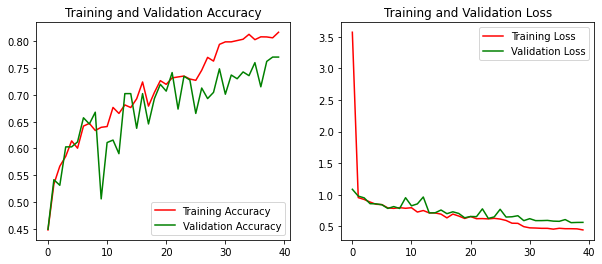

In [ ]:
acc = result_VGG19.history['accuracy']
val_acc = result_VGG19.history['val_accuracy']

loss = result_VGG19.history['loss']
val_loss = result_VGG19.history['val_loss']

epochs=40
epochs_range = range(epochs)


plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy', color = 'red') #, color = 'red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy',color='green')  # , color='blue')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss',color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss',color='green')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


###### Using VGG16

In [ ]:
model_3 = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)  

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
# Freeze convolutional layers
for layer in model_3.layers:
    layer.trainable = False

In [ ]:
VGG16_model = Sequential(
                        [InputLayer(input_shape=INPUT_SHAPE),model_3,
                         Flatten(),  # should be fine , or add layers
                         Dense(3000, activation='relu'),   
                         Dense(1500, activation='relu'),   
                         Dense(4, activation='softmax')]
                       )


In [ ]:
VGG16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 3000)              75267000  
                                                                 
 dense_1 (Dense)             (None, 1500)              4501500   
                                                                 
 dense_2 (Dense)             (None, 4)                 6004      
                                                                 
Total params: 94,489,192
Trainable params: 79,774,504
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
VGG16_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'],)

In [ ]:
result_VGG16 = VGG16_model.fit(train_dataset,epochs=NUM_EPOCHS, callbacks=[callbacks_list],validation_data=val_dataset)

Epoch 1/40
77/77 [==============================] - ETA: 0s - loss: 4.0936 - accuracy: 0.4856
Epoch 00001: val_loss improved from inf to 0.93966, saving model to ./temp/
INFO:tensorflow:Assets written to: ./temp/assets
77/77 [==============================] - 144s 2s/step - loss: 4.0936 - accuracy: 0.4856 - val_loss: 0.9397 - val_accuracy: 0.5104 - lr: 0.0010
Epoch 2/40
77/77 [==============================] - ETA: 0s - loss: 0.8836 - accuracy: 0.5863
Epoch 00002: val_loss improved from 0.93966 to 0.88283, saving model to ./temp/
INFO:tensorflow:Assets written to: ./temp/assets
77/77 [==============================] - 98s 1s/step - loss: 0.8836 - accuracy: 0.5863 - val_loss: 0.8828 - val_accuracy: 0.5498 - lr: 0.0010
Epoch 3/40
77/77 [==============================] - ETA: 0s - loss: 0.8252 - accuracy: 0.6224
Epoch 00003: val_loss improved from 0.88283 to 0.84004, saving model to ./temp/
INFO:tensorflow:Assets written to: ./temp/assets
77/77 [==============================] - 96s 1s/st

### **Plot** **Graph** 

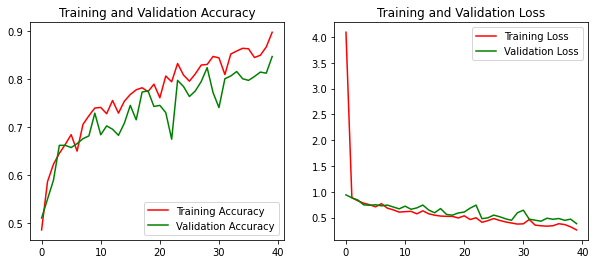

In [ ]:
acc = result_VGG16.history['accuracy']
val_acc = result_VGG16.history['val_accuracy']

loss = result_VGG16.history['loss']
val_loss = result_VGG16.history['val_loss']

epochs=40
epochs_range = range(epochs)


plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy', color = 'red') #, color = 'red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy',color='green')  # , color='blue')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss',color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss',color='green')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

###### Using InceptionV3

In [ ]:
model_4 = InceptionV3(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)  

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
# Freeze convolutional layers
for layer in model_4.layers:
    layer.trainable = False

In [ ]:
transferV3_model = Sequential(
                        [InputLayer(input_shape=INPUT_SHAPE),model_4,
                         Flatten(),  
                         Dense(3000, activation='relu'),   
                         Dense(1500, activation='relu'),   
                         Dense(4, activation='softmax')]
                       )

In [ ]:
transferV3_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dense_6 (Dense)             (None, 3000)              153603000 
                                                                 
 dense_7 (Dense)             (None, 1500)              4501500   
                                                                 
 dense_8 (Dense)             (None, 4)                 6004      
                                                                 
Total params: 179,913,288
Trainable params: 158,110,504
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
transferV3_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'],)

In [ ]:
result_InceptionV3 = transferV3_model.fit(train_dataset,epochs=NUM_EPOCHS, callbacks=[callbacks_list],validation_data=val_dataset)

Epoch 1/40
77/77 [==============================] - ETA: 0s - loss: 13.3138 - accuracy: 0.4711
Epoch 00001: val_loss did not improve from 0.48731
77/77 [==============================] - 99s 1s/step - loss: 13.3138 - accuracy: 0.4711 - val_loss: 0.9555 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 2/40
77/77 [==============================] - ETA: 0s - loss: 0.9252 - accuracy: 0.5671
Epoch 00002: val_loss did not improve from 0.48731
77/77 [==============================] - 86s 1s/step - loss: 0.9252 - accuracy: 0.5671 - val_loss: 0.9329 - val_accuracy: 0.5856 - lr: 0.0010
Epoch 3/40
77/77 [==============================] - ETA: 0s - loss: 0.8735 - accuracy: 0.5961
Epoch 00003: val_loss did not improve from 0.48731
77/77 [==============================] - 86s 1s/step - loss: 0.8735 - accuracy: 0.5961 - val_loss: 0.9113 - val_accuracy: 0.5845 - lr: 0.0010
Epoch 4/40
77/77 [==============================] - ETA: 0s - loss: 0.8517 - accuracy: 0.6100
Epoch 00004: val_loss did not improve from 

### **Plot** **Graph** 

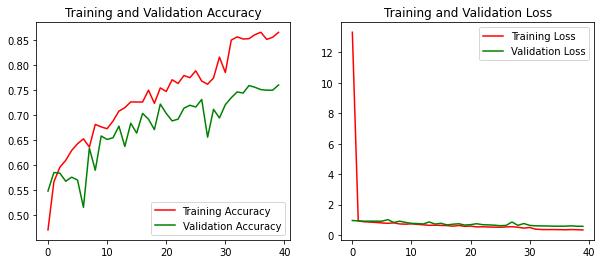

In [ ]:
acc = result_InceptionV3.history['accuracy']
val_acc = result_InceptionV3.history['val_accuracy']

loss = result_InceptionV3.history['loss']
val_loss = result_InceptionV3.history['val_loss']

epochs=40
epochs_range = range(epochs)


plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy', color = 'red') #, color = 'red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy',color='green')  # , color='blue')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss',color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss',color='green')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

### **Final** **Result**


### The best model transfer learning from MobileNetV2 (accuracy =  0.9508) 

### **Test**

In [ ]:
print("Accuracy of our model on test data : " , mobilenet.evaluate(test_dataset)[1]*100 , "%")

10/10 [==============================] - 3s 321ms/step - loss: 0.4985 - accuracy: 0.8263
Accuracy of our model on test data :  82.62910842895508 %
